In [1]:
import pandas as pd
import numpy as np
# import sqlalchemy
import matplotlib.pyplot as plt
import re
import sys
import p5lib
import pickle
import os.path

%matplotlib inline

In [2]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = p5lib.preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


In [3]:
col_desc = p5lib.col_desc
print len(col_desc)

51


In [4]:

def print_num_data_for_each_features(data):
    print "Number of available data for each feature (not counting the NaN values)"
    tmp = (data.isnull().sum() - len(data)) * -1
    for k, v in tmp.iteritems(): 
        print "{0:20s}{1:45s}{2:5d}".format(k, col_desc[k], v)

# There is not a single college that has all the data for all features
print "Num of rows that has all the features: {}".format(len(data.dropna()))
print "-----"

print_num_data_for_each_features(data)

Num of rows that has all the features: 0
-----
Number of available data for each feature (not counting the NaN values)
ACTCMMID            ACT                                           1327
ADM_RATE_ALL        Admission rate                                2065
AVGFACSAL           Avg faculty salary                            3794
CCBASIC             Carnegie classification-basic                 3643
CCSIZSET            Carnegie classification-Size & settings       3286
CCUGPROF            Carnegie classification-Undergrad profile     3286
CONTROL             Control (public/private)                      6007
COSTT4_A            Avg cost academic year                        3691
COSTT4_P            Avg cost program year                         2249
DEBT_MDN            Median debt                                   5242
DEP_INC_AVG         Avg income dependent stu                      5703
DISTANCEONLY        Distance only                                 6007
GRAD_DEBT_MDN       Median de

In [5]:
# show statistical analysis of the data

data['L4_COLLEGE'] = data['L4_COLLEGE'].astype(int)
# data_stat = data.describe().round(3)
# print data_stat.shape
# for i in range(0, len(data_stat.columns)/5 + 1):
#     print data_stat[data_stat.columns[i*5:(i*5)+5]]
    
print data.C150.describe()
print data.RET_FT.describe()

count    6007.000000
mean        0.526462
std         0.237548
min         0.000000
25%         0.333350
50%         0.551705
75%         0.717280
max         1.000000
Name: C150, dtype: float64
count    6007.000000
mean        0.692658
std         0.178662
min         0.000000
25%         0.587750
50%         0.707400
75%         0.818200
max         1.000000
Name: RET_FT, dtype: float64


In [6]:
print_num_data_for_each_features(data)

Number of available data for each feature (not counting the NaN values)
ACTCMMID            ACT                                           1327
ADM_RATE_ALL        Admission rate                                2065
AVGFACSAL           Avg faculty salary                            3794
CCBASIC             Carnegie classification-basic                 3643
CCSIZSET            Carnegie classification-Size & settings       3286
CCUGPROF            Carnegie classification-Undergrad profile     3286
CONTROL             Control (public/private)                      6007
COSTT4_A            Avg cost academic year                        3691
COSTT4_P            Avg cost program year                         2249
DEBT_MDN            Median debt                                   5242
DEP_INC_AVG         Avg income dependent stu                      5703
DISTANCEONLY        Distance only                                 6007
GRAD_DEBT_MDN       Median debt complete                          5186
IND_I

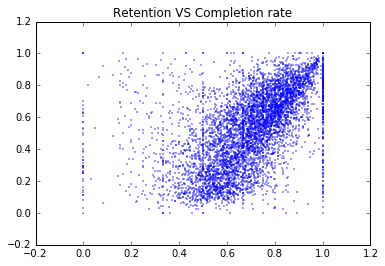

In [7]:
plt.scatter(data['RET_FT'], data['C150'], c='b', s=2, linewidths=0)
plt.title('Retention VS Completion rate')
plt.show()

In [8]:
print len(data['RET_FT'][data['RET_FT'] == 1])
print len(data['RET_FT'][data['RET_FT'] == 0])
print len(data['C150'][data['C150'] == 1])
print len(data['C150'][data['C150'] == 0])

249
47
39
13


In [9]:
faculty_cols = ['AVGFACSAL', 'PFTFAC', 'ADM_RATE_ALL']
stu_score_cols = ['ACTCMMID', 'SAT_AVG', 'SAT_AVG_ALL', 'SATVRMID', 'SATMTMID', 'SATWRMID']
cost_cols = ['COSTT4_A', 'COSTT4_P', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITIONFEE_PROG', 'TUITFTE', 
             'INEXPFTE', 'NPT4']
grant_loan_cols = ['PCTPELL', 'PCTFLOAN']
stu_composition_cols = ['NUM4', 'UG25abv', 'PFTFTUG1_EF', 'UGDS', 'PAR_ED_PCT_1STGEN', 
                        'PAR_ED_PCT_MS', 'PAR_ED_PCT_HS', 
                        'PAR_ED_PCT_PS', 'DEP_INC_AVG', 'IND_INC_AVG']
debt_cols = ['DEBT_MDN', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN']

# print (len(faculty_cols) + len(stu_score_cols) + len(cost_cols) + len(grant_loan_cols) +
#     len(stu_composition_cols) + len(debt_cols))
# set(col_desc.keys()) - set(faculty_cols + stu_score_cols + cost_cols + grant_loan_cols +
#     stu_composition_cols + debt_cols)

In [10]:
# for col in col_desc.keys():
#     if data.dtypes[col] == 'object':
#         data[col] = data[col].replace(['PrivacySuppressed'], [float('NaN')]).astype(float)
#     print "-----"
#     print "{}:".format(col_desc[col])
#     print data[col].describe()


In [11]:
# For plotting purpose, split data based on:
#   4 year college and <4 year college
#   public, private and private for profit category

data_L4 = data[data['L4_COLLEGE'] == 1]
data_4  = data[data['L4_COLLEGE'] == 0]

data_control1 = data[data.CONTROL == 1] # public
data_control2 = data[data.CONTROL == 2] # private non-profit
data_control3 = data[data.CONTROL == 3] # private profit

# print data['L4_COLLEGE']
# print data.columns
# print data_4.columns
# print data_L4.columns

In [12]:
# print len(data_control1)
# print len(data_control1['NPT4_PUB'].dropna())
# print len(data_control1['NPT4_PRIV'].dropna())
# print '---'
# print len(data_control2)
# print len(data_control2['NPT4_PUB'].dropna())
# print len(data_control2['NPT4_PRIV'].dropna())
# print '---'
# print len(data_control3)
# print len(data_control3['NPT4_PUB'].dropna())
# print len(data_control3['NPT4_PRIV'].dropna())


Avg faculty salary VS completion


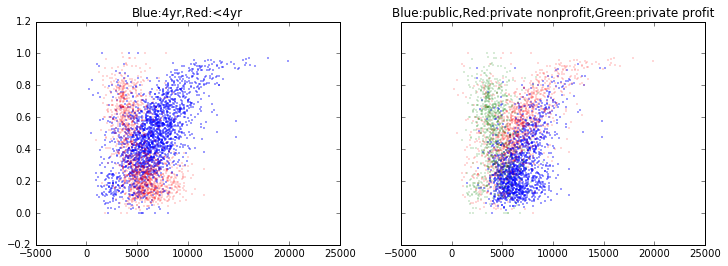

Avg faculty salary VS retention


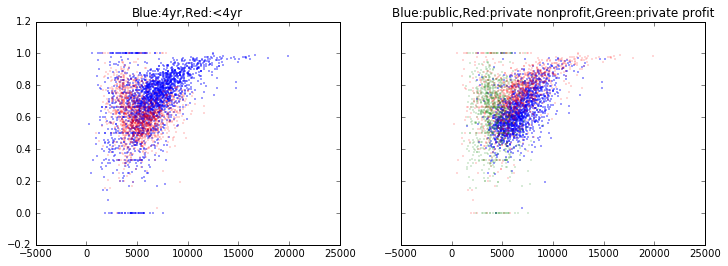

Full time faculty rate VS completion


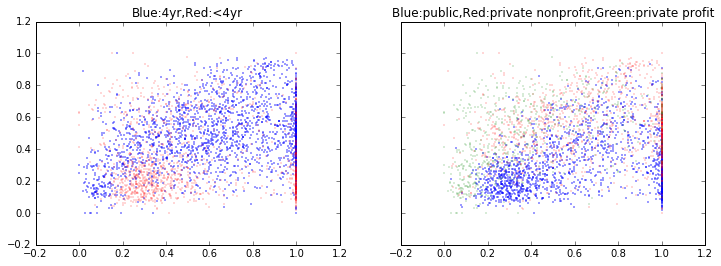

Full time faculty rate VS retention


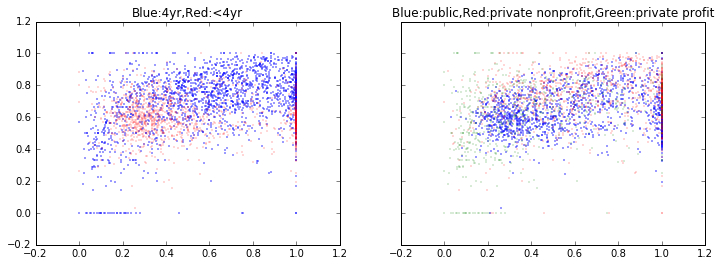

Admission rate VS completion


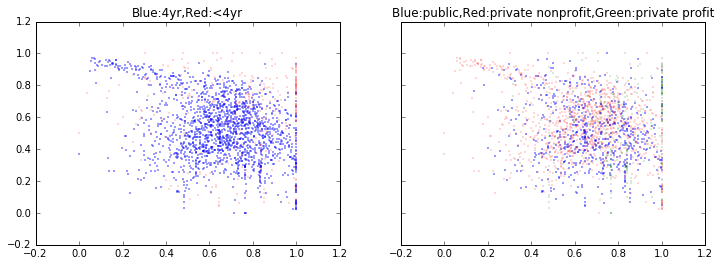

Admission rate VS retention


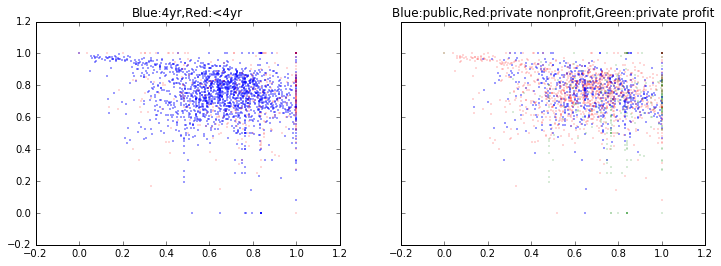

In [13]:
def plot_feature_vs_completion(cols, xscale=None):
    for col in cols:
        print "{} VS completion".format(col_desc[col])
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
        ax1.scatter(data_4[col], data_4['C150'], c='b', s=2, linewidths=0)
        ax1.scatter(data_L4[col], data_L4['C150'], c='r', s=2, linewidths=0, alpha=0.4)
        ax1.set_title("Blue:4yr,Red:<4yr")
        if xscale:
            ax1.set_xscale(xscale)
        
        ax2.scatter(data_control1[col], data_control1['C150'], c='b', s=2, linewidths=0)
        ax2.scatter(data_control2[col], data_control2['C150'], c='r', s=2, linewidths=0, alpha=0.4)
        ax2.scatter(data_control3[col], data_control3['C150'], c='g', s=2, linewidths=0, alpha=0.4)
        ax2.set_title("Blue:public,Red:private nonprofit,Green:private profit")
        if xscale:
            ax2.set_xscale(xscale)

        plt.show()

def plot_feature_vs_retention(cols, xscale=None):
    for col in cols:
        print "{} VS retention".format(col_desc[col])
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
        ax1.scatter(data_4[col], data_4['RET_FT'], c='b', s=2, linewidths=0)
        ax1.scatter(data_L4[col], data_L4['RET_FT'], c='r', s=2, linewidths=0, alpha=0.4)
        ax1.set_title("Blue:4yr,Red:<4yr")
        if xscale:
            ax1.set_xscale(xscale)
        
        ax2.scatter(data_control1[col], data_control1['RET_FT'], c='b', s=2, linewidths=0)
        ax2.scatter(data_control2[col], data_control2['RET_FT'], c='r', s=2, linewidths=0, alpha=0.4)
        ax2.scatter(data_control3[col], data_control3['RET_FT'], c='g', s=2, linewidths=0, alpha=0.4)
        ax2.set_title("Blue:public,Red:private nonprofit,Green:private profit")
        if xscale:
            ax2.set_xscale(xscale)

        plt.show()

# print data_4.columns
for col in faculty_cols:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])

Carnegie classification-Size & settings VS completion


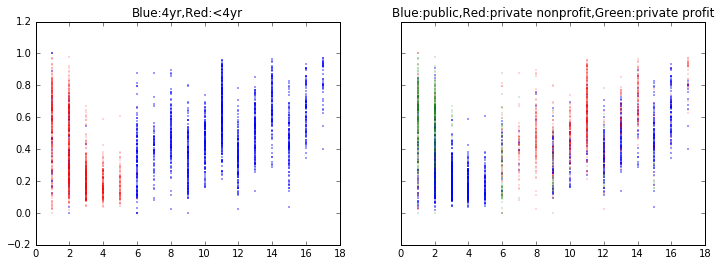

Carnegie classification-Size & settings VS retention


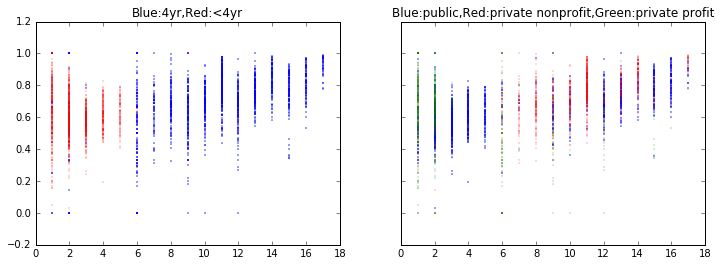

Carnegie classification-Undergrad profile  VS completion


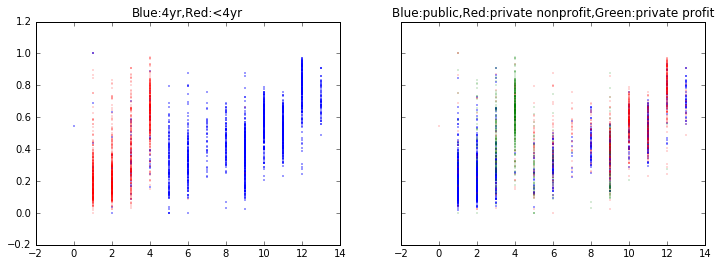

Carnegie classification-Undergrad profile  VS retention


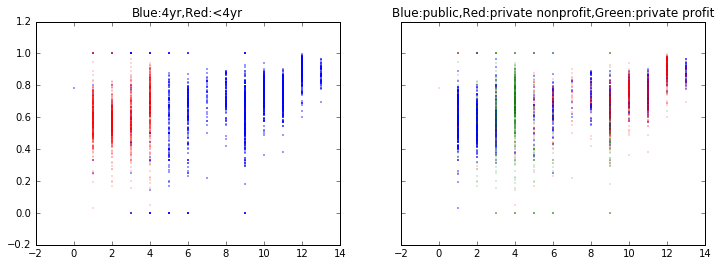

Carnegie classification-basic VS completion


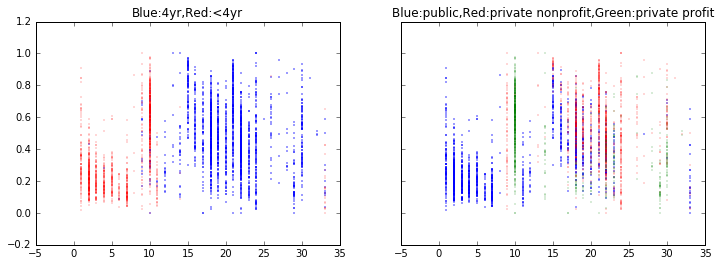

Carnegie classification-basic VS retention


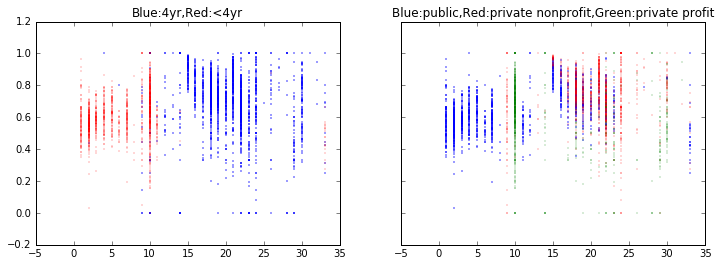

Locale VS completion


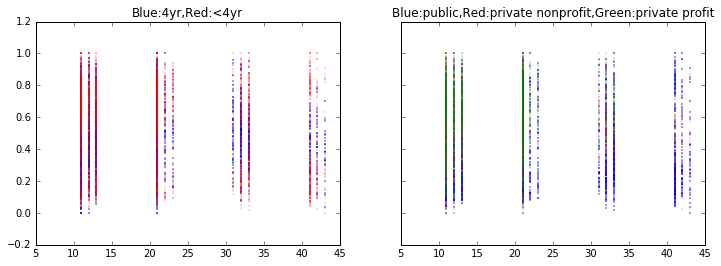

Locale VS retention


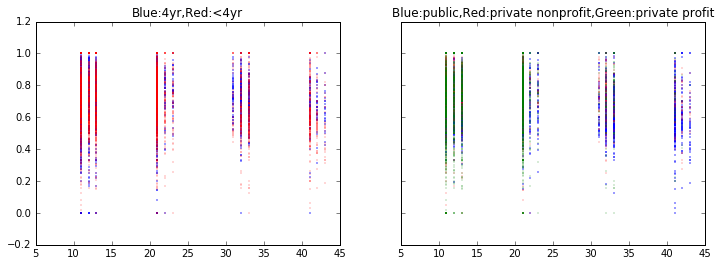

region VS completion


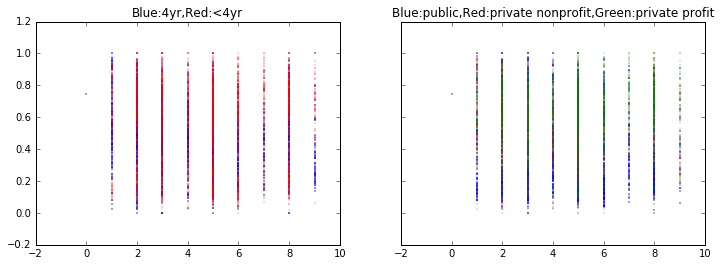

region VS retention


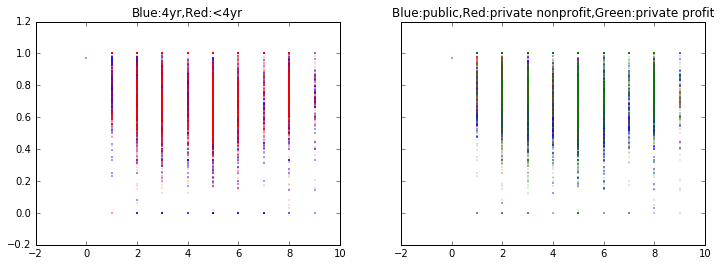

Predominant degree VS completion


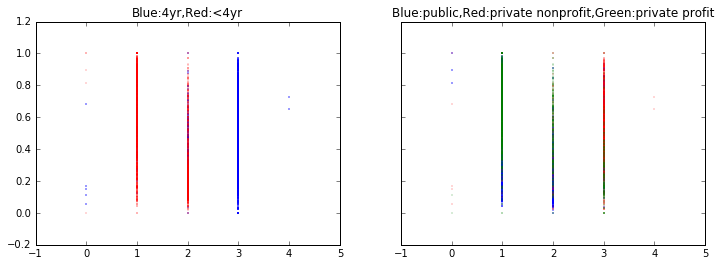

Predominant degree VS retention


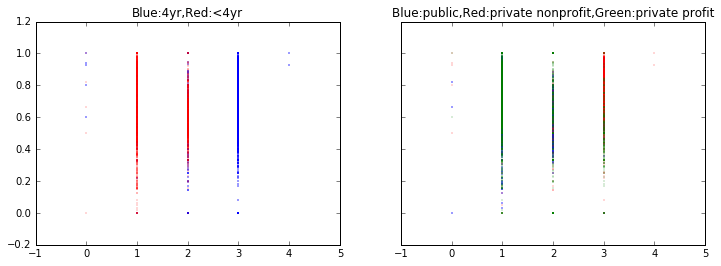

In [14]:
for col in ['CCSIZSET', 'CCUGPROF', 'CCBASIC', 'LOCALE', 'region', 'PREDDEG']:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])

ACT VS completion


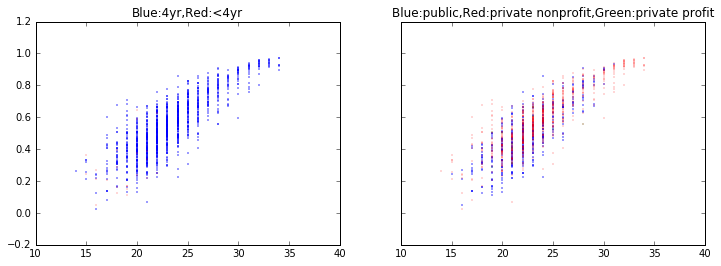

ACT VS retention


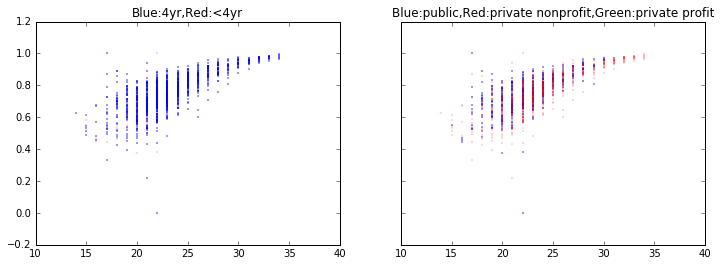

SAT VS completion


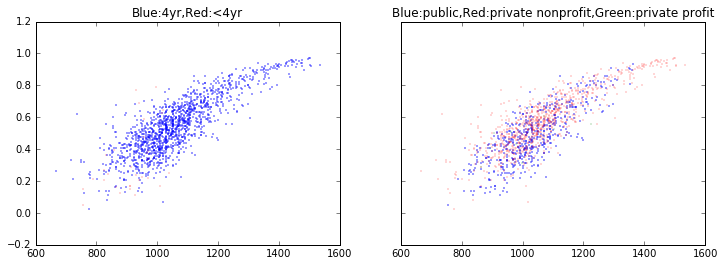

SAT VS retention


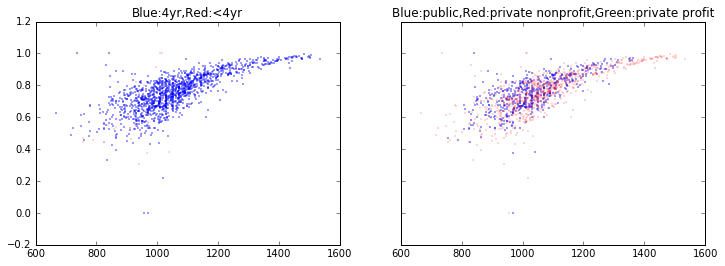

SAT all VS completion


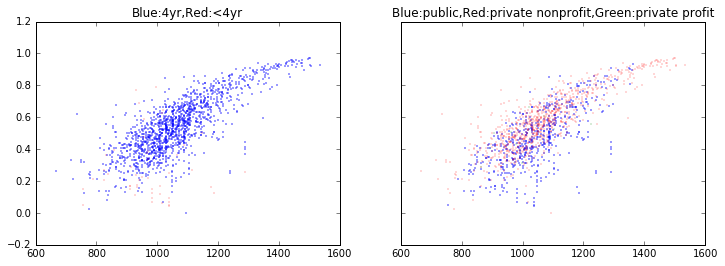

SAT all VS retention


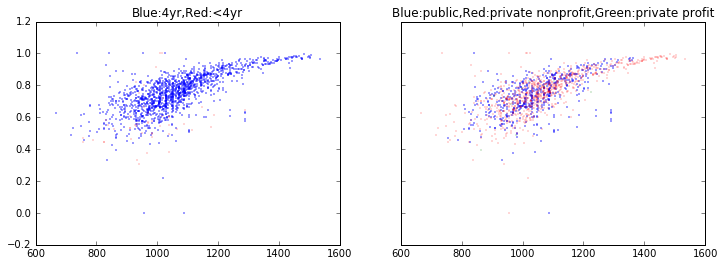

SAT reading VS completion


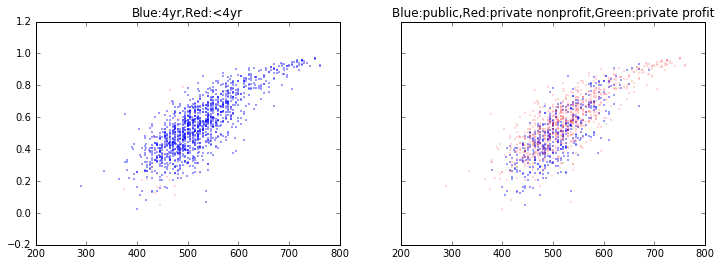

SAT reading VS retention


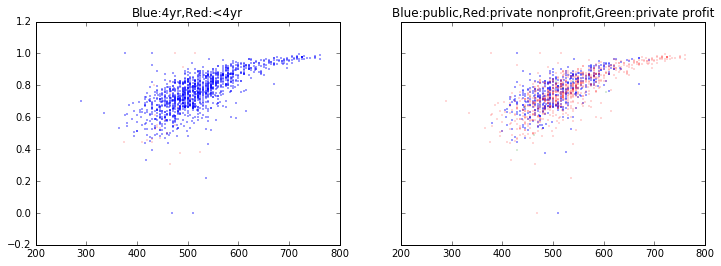

SAT math VS completion


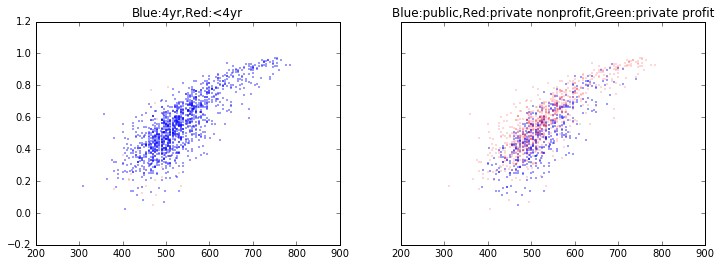

SAT math VS retention


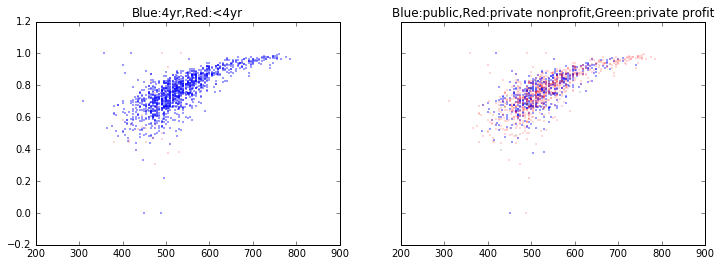

SAT writing VS completion


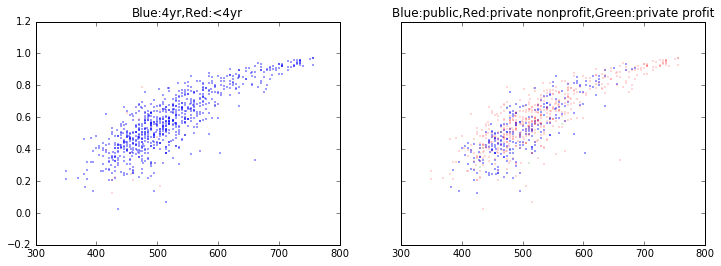

SAT writing VS retention


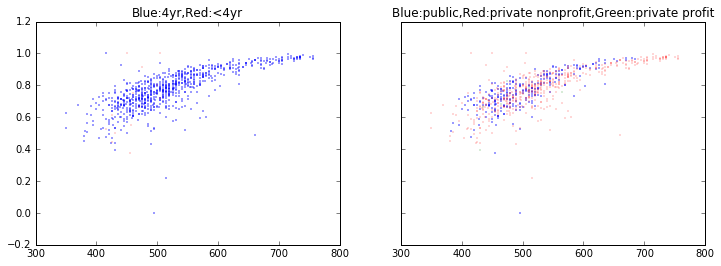

In [15]:
for col in stu_score_cols:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])

Avg cost academic year VS completion


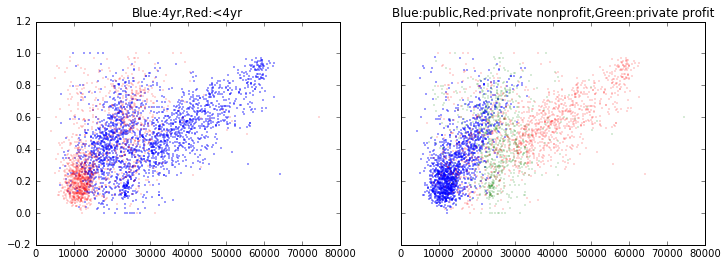

Avg cost academic year VS retention


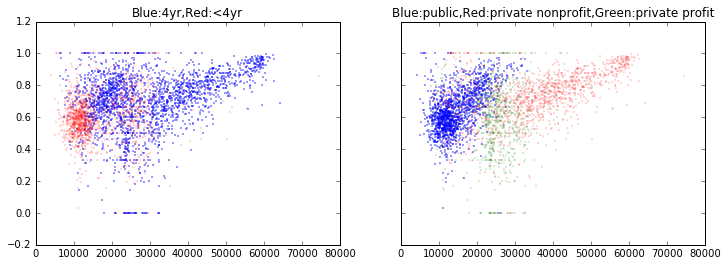

Avg cost program year VS completion


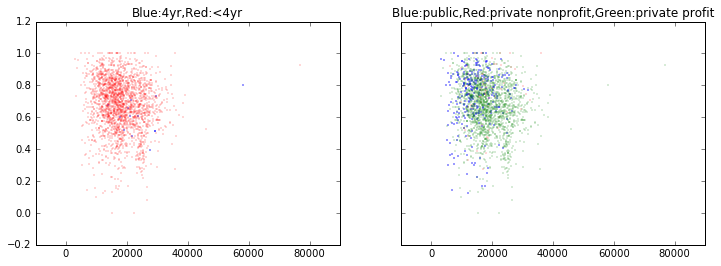

Avg cost program year VS retention


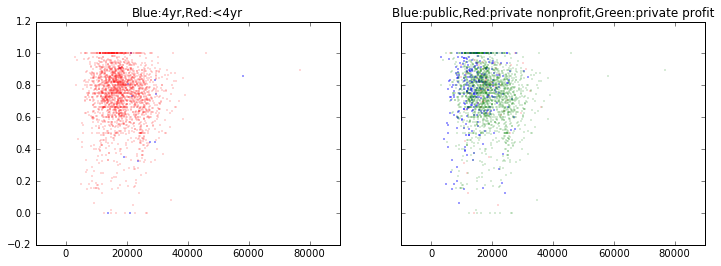

In state tuition VS completion


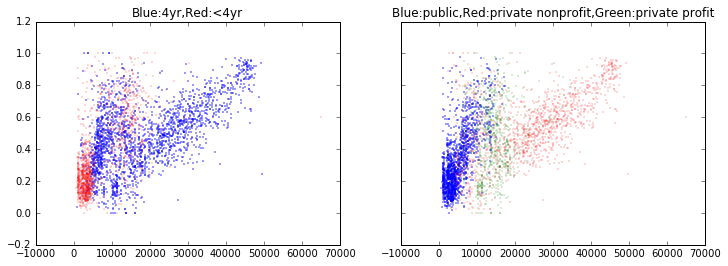

In state tuition VS retention


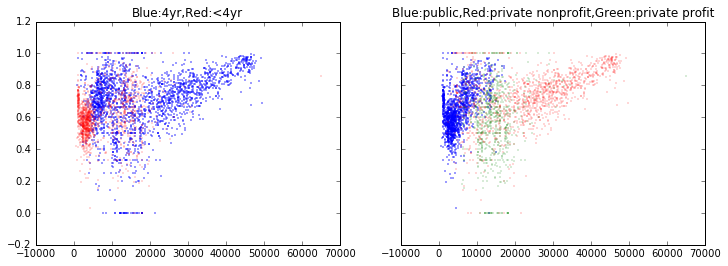

Out of state tuition VS completion


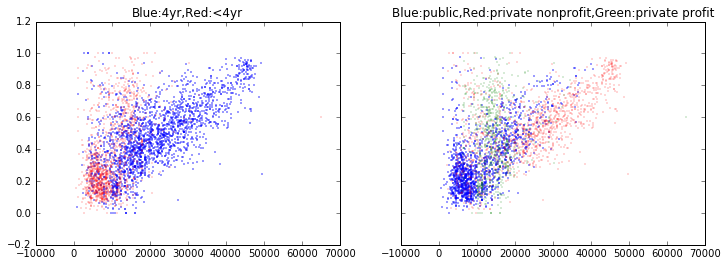

Out of state tuition VS retention


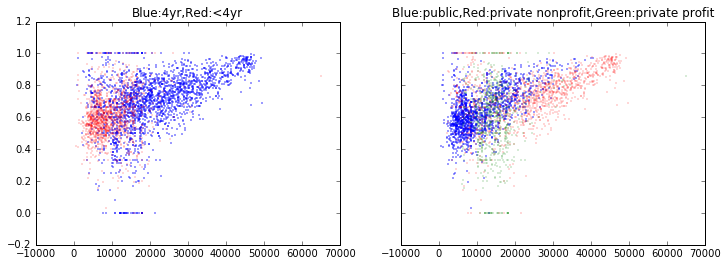

Tuition fee program year VS completion


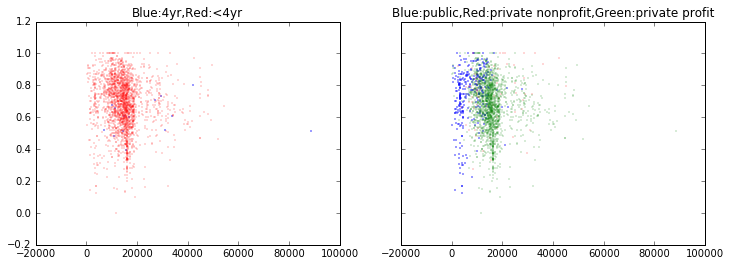

Tuition fee program year VS retention


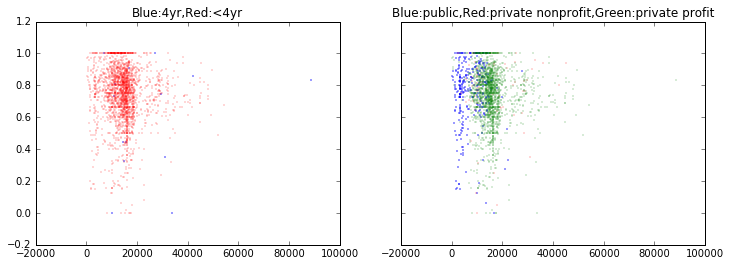

In [16]:
for col in cost_cols[:5]:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])

Net revenue per FTE student VS completion


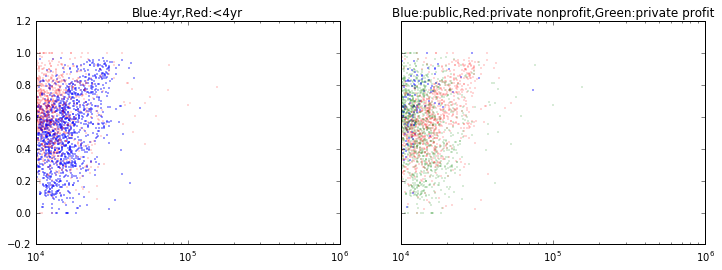

Net revenue per FTE student VS retention


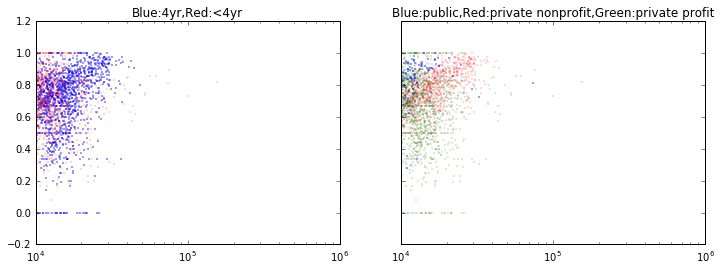

Expense per FTE student VS completion


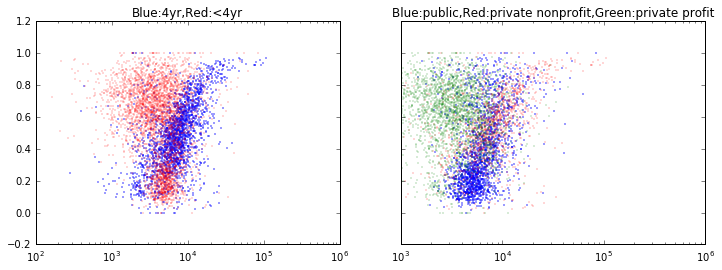

Expense per FTE student VS retention


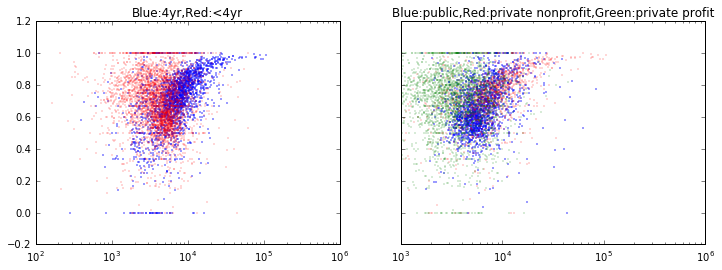

Avg net price Title IV VS completion


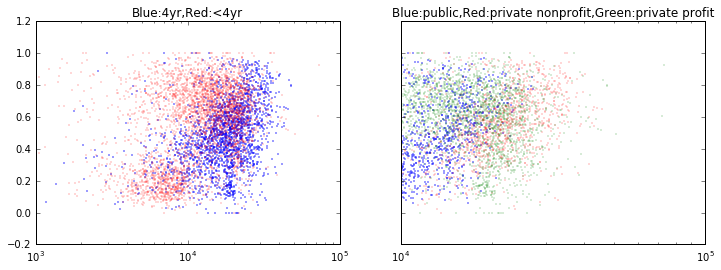

Avg net price Title IV VS retention


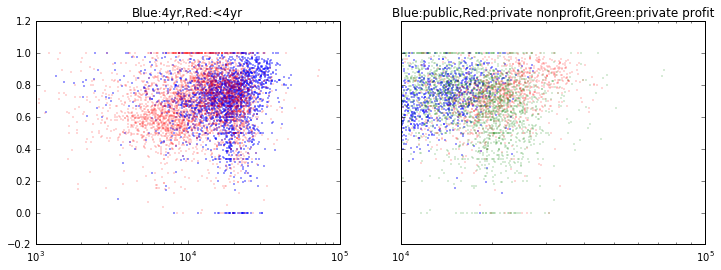

In [17]:
for col in cost_cols[5:]:
    plot_feature_vs_completion([col], xscale='log')
    plot_feature_vs_retention([col], xscale='log')


% Pell Grant receiver VS completion


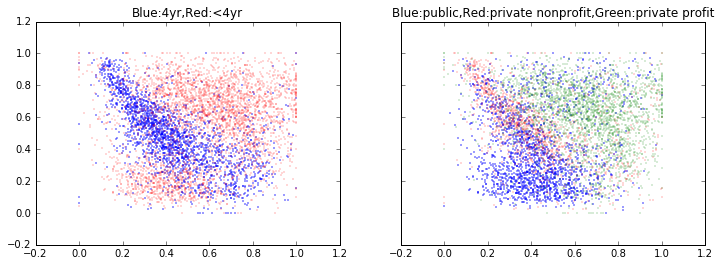

% Pell Grant receiver VS retention


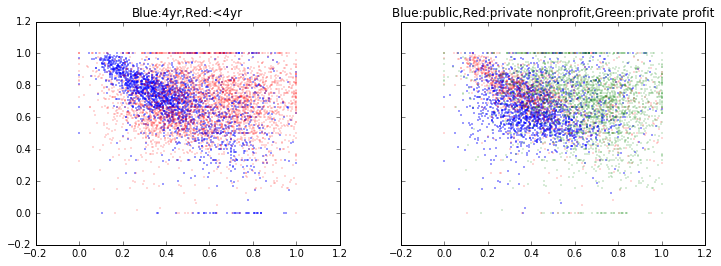

% Fed student loan VS completion


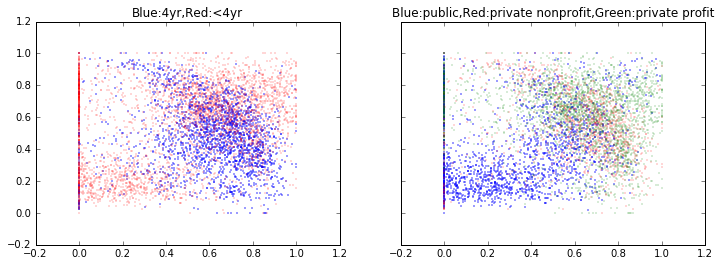

% Fed student loan VS retention


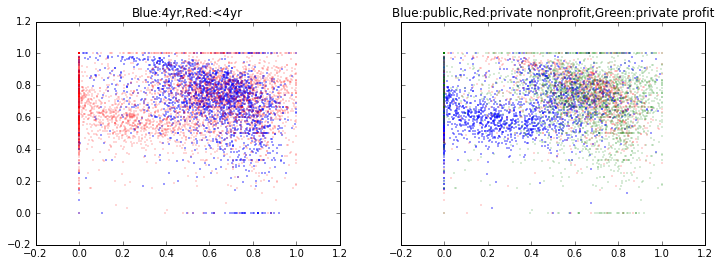

In [18]:
for col in grant_loan_cols:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])

Num Title IV student VS completion


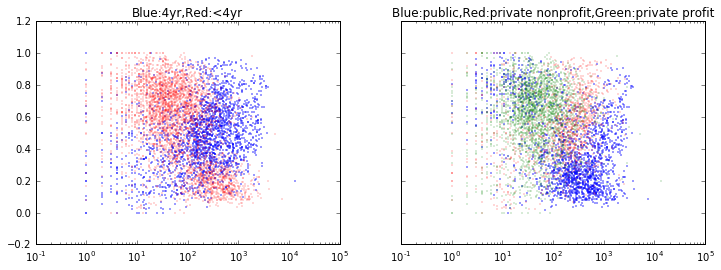

Num Title IV student VS retention


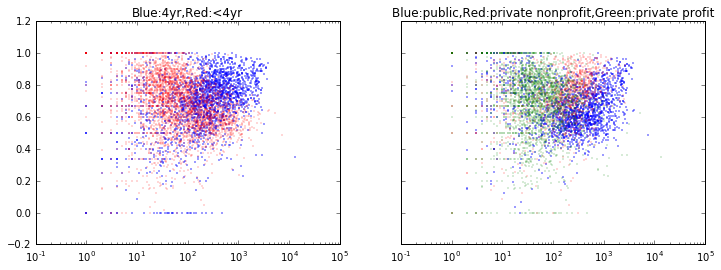

Number of Undergrad degree seeking VS completion


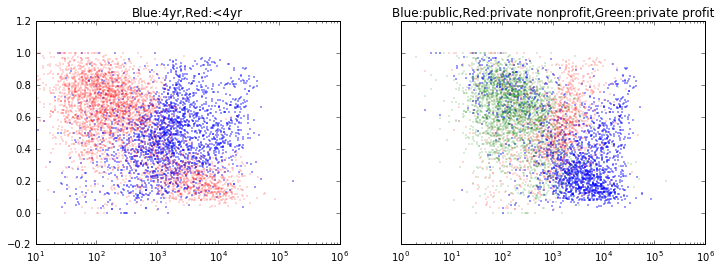

Number of Undergrad degree seeking VS retention


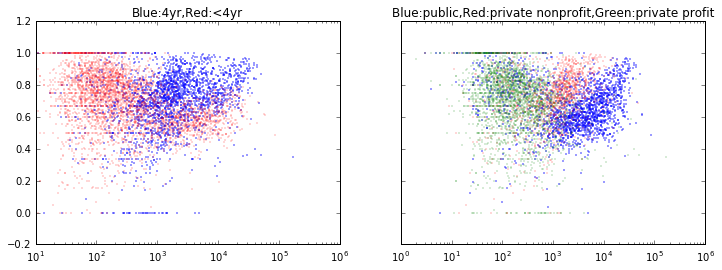

% undergrad > 25 yr VS completion


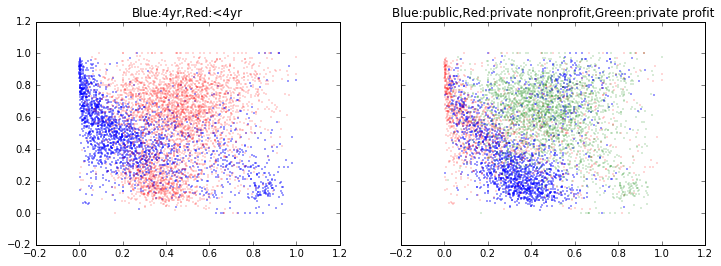

% undergrad > 25 yr VS retention


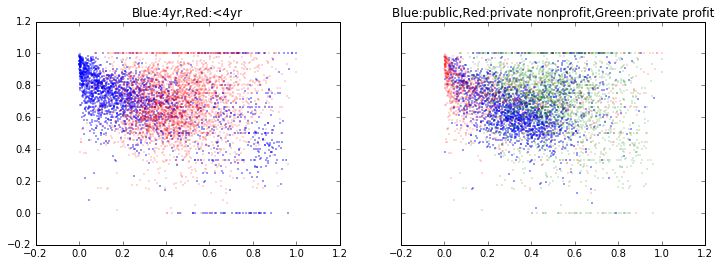

Undergrad 1st-time degree seeking VS completion


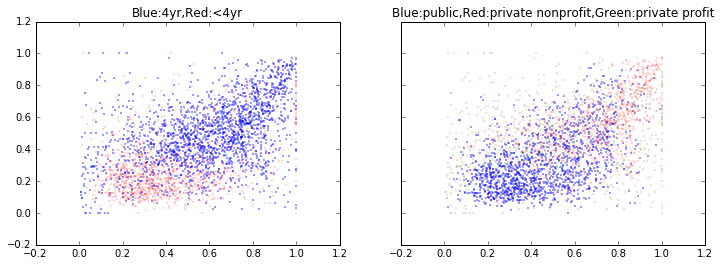

Undergrad 1st-time degree seeking VS retention


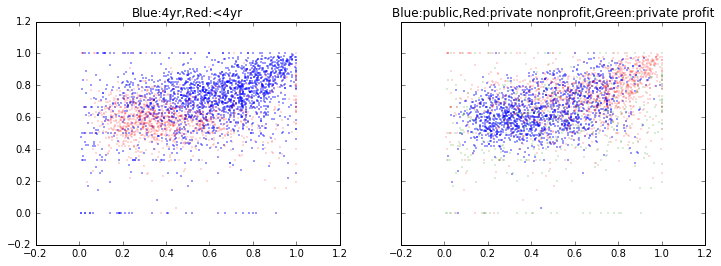

In [19]:
# print stu_composition_cols
plot_feature_vs_completion(['NUM4'], xscale='log')
plot_feature_vs_retention(['NUM4'], xscale='log')
plot_feature_vs_completion(['UGDS'], xscale='log')
plot_feature_vs_retention(['UGDS'], xscale='log')
for col in ['UG25abv', 'PFTFTUG1_EF']:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])


% parent education middle school VS completion


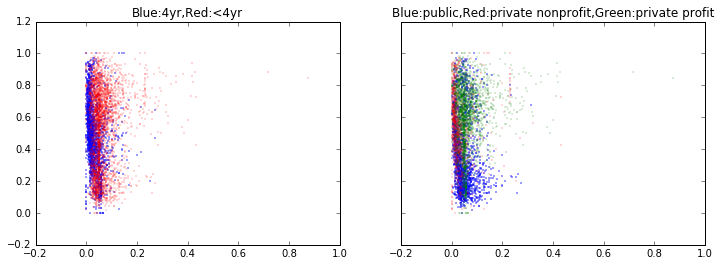

% parent education middle school VS retention


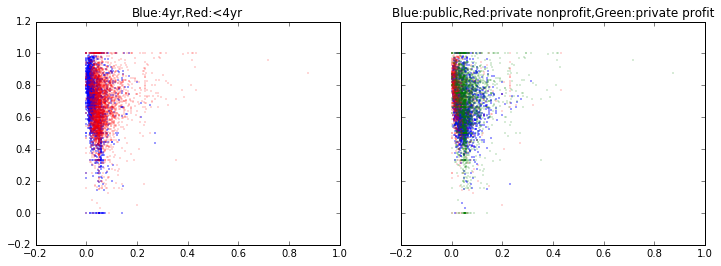

% parent education high school VS completion


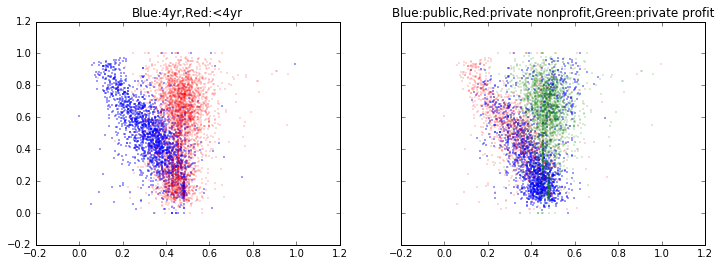

% parent education high school VS retention


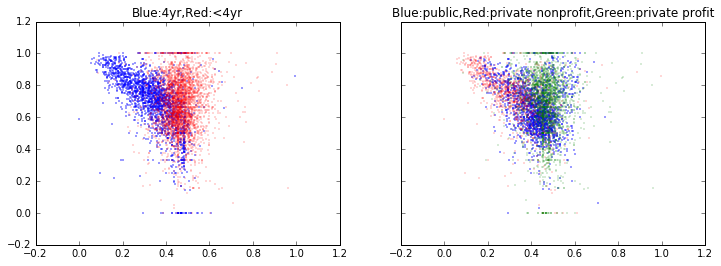

% parent education post secondary VS completion


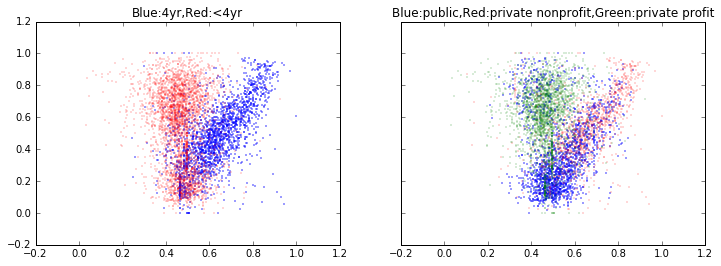

% parent education post secondary VS retention


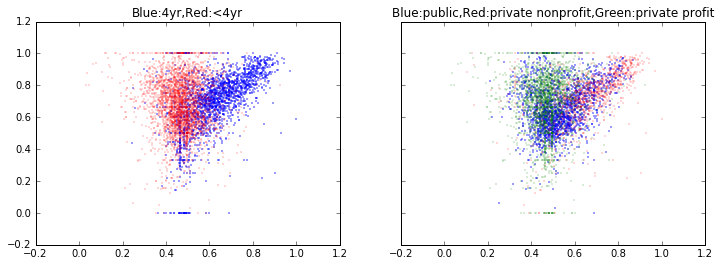

Avg income dependent stu VS completion


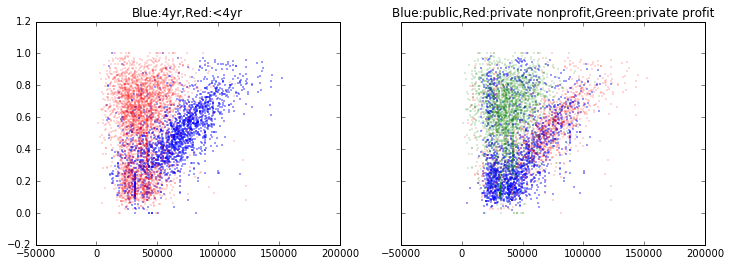

Avg income dependent stu VS retention


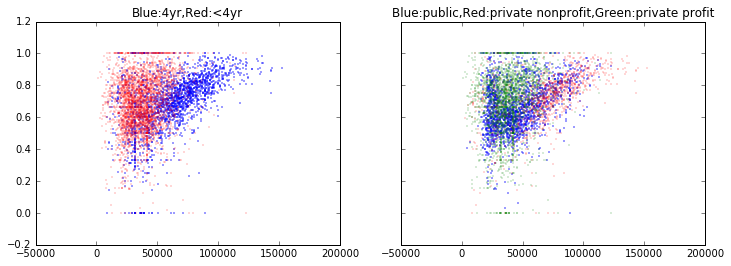

Avg income independent stu VS completion


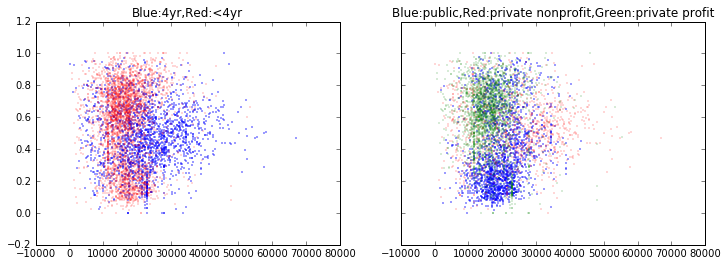

Avg income independent stu VS retention


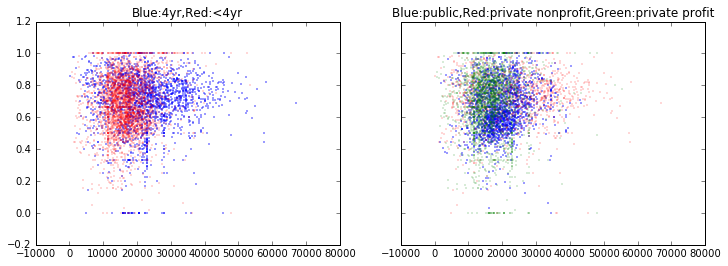

In [20]:
# print stu_composition_cols
for col in stu_composition_cols[5:10]:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])

Median debt VS completion


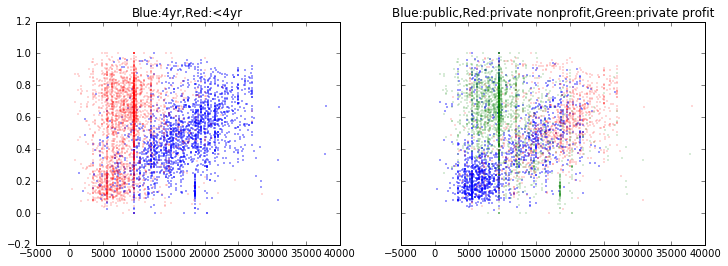

Median debt VS retention


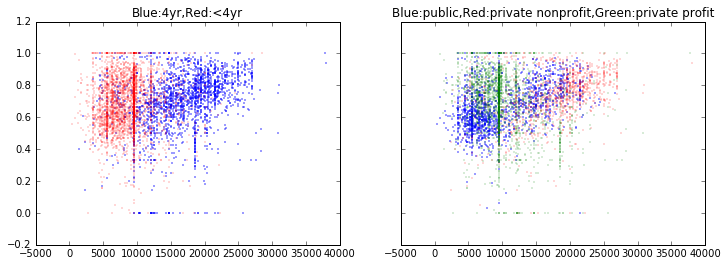

Median debt complete VS completion


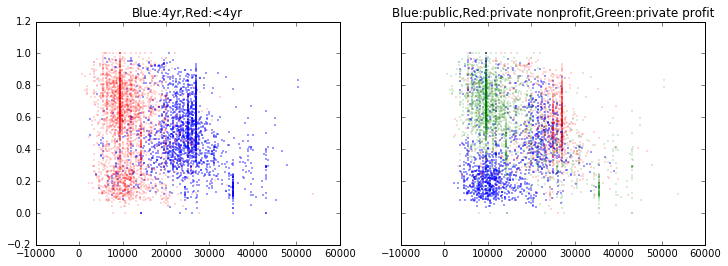

Median debt complete VS retention


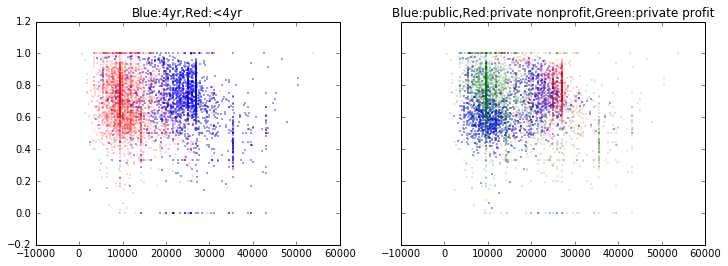

Median debt non-completer VS completion


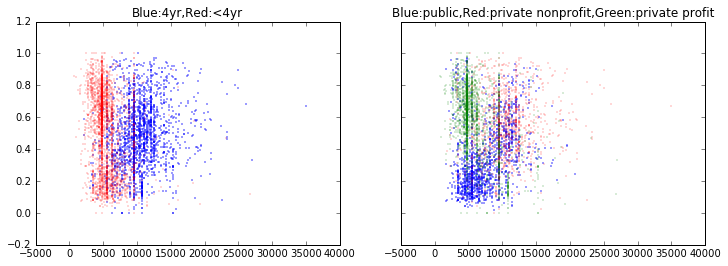

Median debt non-completer VS retention


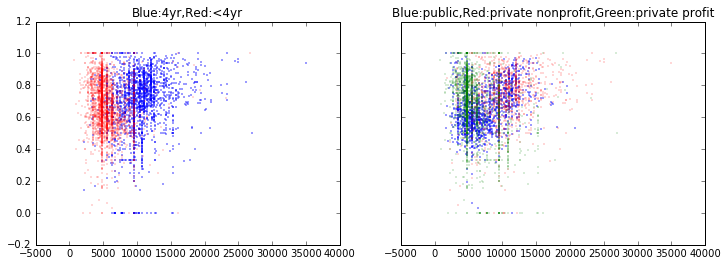

In [21]:
for col in debt_cols:
    plot_feature_vs_completion([col])
    plot_feature_vs_retention([col])